In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from models import spatial_flu as sf
from scipy import integrate

reload(sf);

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

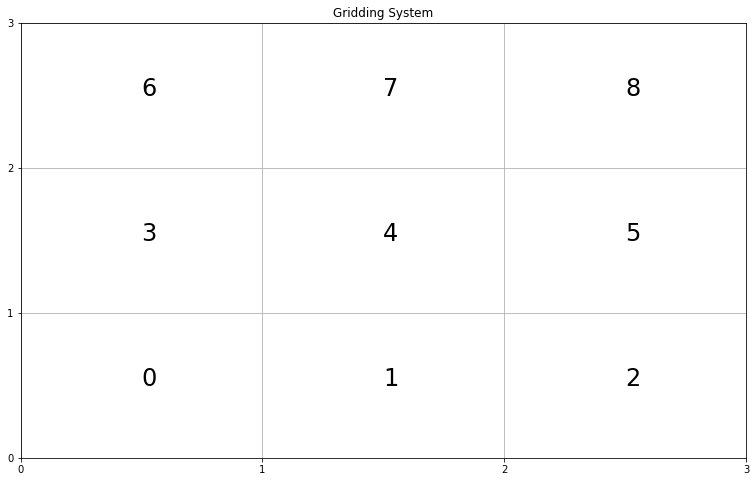

In [18]:
plt.figure()
plt.title("Gridding System")
plt.axis([0, 3, 0, 3],)
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.grid()
for i in range(3):
    for j in range(3):
        plt.text(i+0.5, j+0.5, str(i+j*3), fontsize=24)

In [4]:
# [death rate, r_0, 1/immunity duration, vaccination rate/4, 1/infectious period, 
#  chance S moves to adjacent cell, chance I moves, chance R moves]
parameters = [0.01, 1.6, 1/3, (0.2)/4, 1/(1/12), 0.1, 0.005, 0.075]

func = lambda t, y: sf.model(t, y, parameters)

infect_fraction = 1e-5
initial_state = [1]*9 + [0]*9 + [0]*9
initial_state[4::9] = [1-infect_fraction, infect_fraction, 0]

solution = integrate.solve_ivp(func, [0, 50], initial_state, max_step=1/12, dense_output=True)

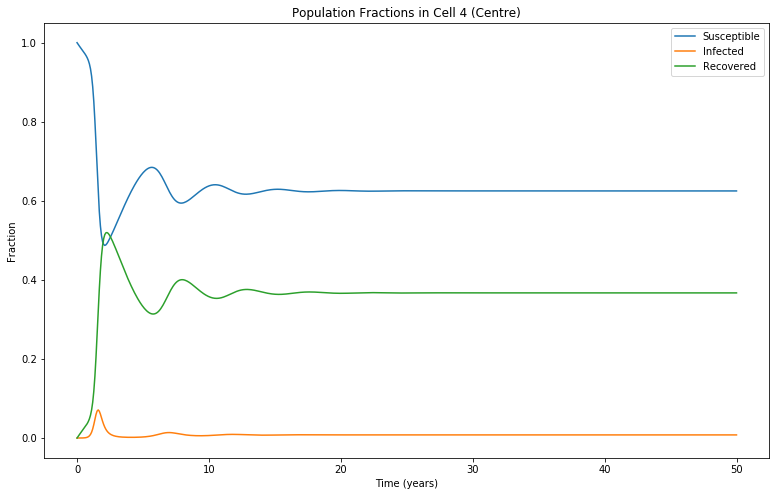

In [5]:
plt.figure()
plt.plot(solution.t, solution.y[4::9].T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cell 4 (Centre)")
plt.legend(["Susceptible", "Infected", "Recovered"])

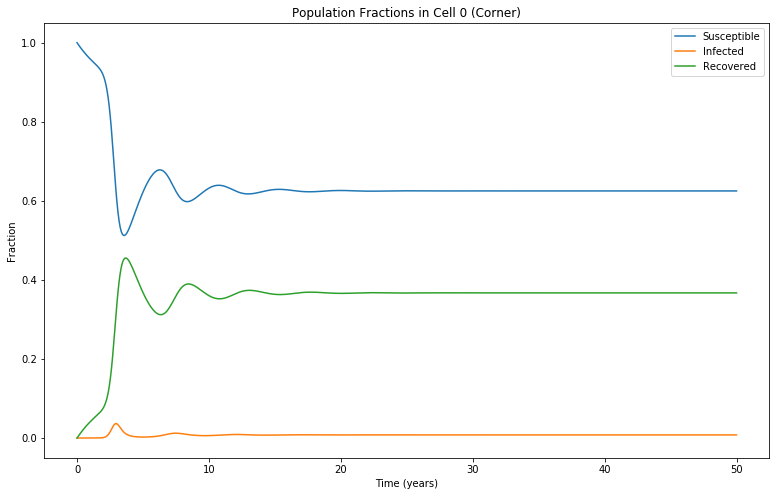

In [6]:
plt.figure()
plt.plot(solution.t, solution.y[::9].T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cell 0 (Corner)")
plt.legend(["Susceptible", "Infected", "Recovered"])

Text(0.5, 1.0, 'Population Fractions in All Cells')

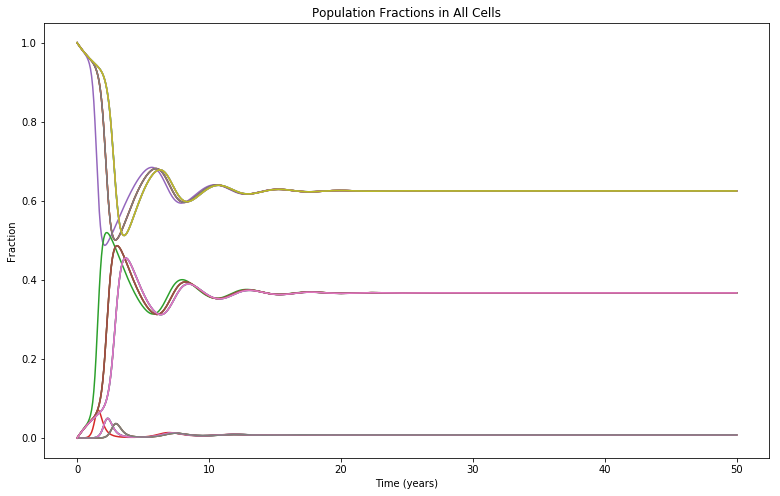

In [7]:
plt.figure()
plt.plot(solution.t, solution.y.T)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in All Cells")

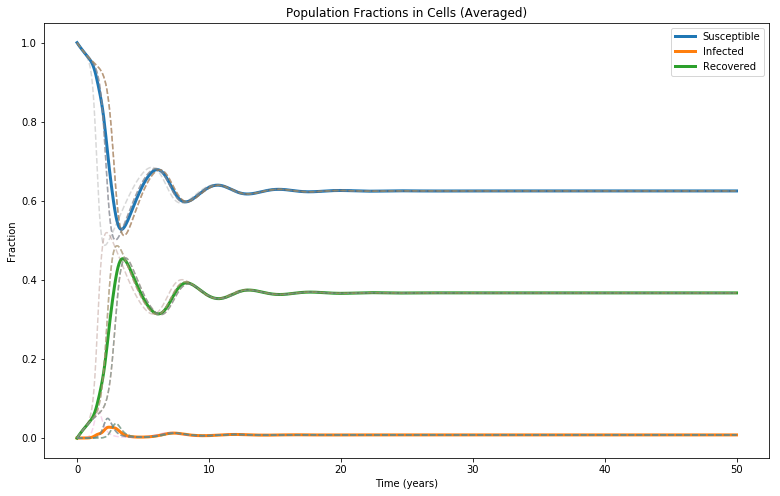

In [16]:
def aug(array, section_size):
    return np.vstack([np.mean(array[i:i+section_size], axis=0) for i in range(0, len(array), section_size)])

averagey = aug(solution.y, 9)

plt.figure()
plt.plot(solution.t, averagey.T, linewidth=3)
plt.plot(solution.t, solution.y.T, '--', alpha=0.3)
plt.xlabel("Time (years)")
plt.ylabel("Fraction")
plt.title("Population Fractions in Cells (Averaged)")
plt.legend(["Susceptible", "Infected", "Recovered"])

Text(0, 0.5, 'Infecteds')

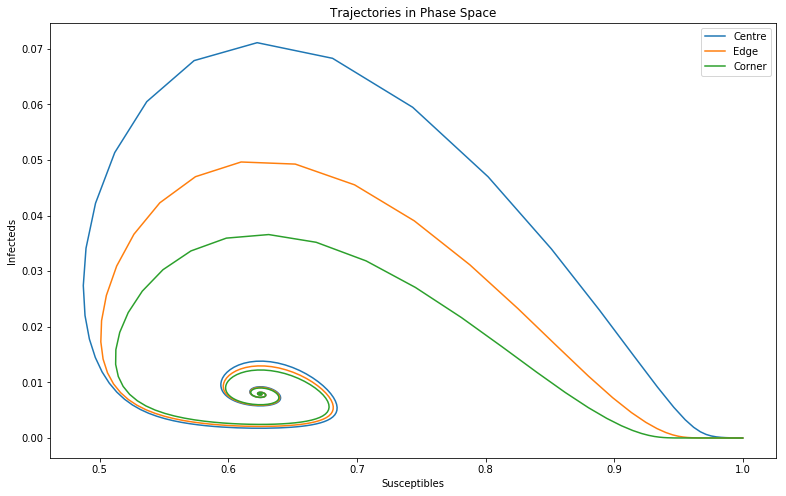

In [9]:
plt.figure()
# plt.plot(averagey[0], averagey[1])
plt.plot(solution.y[4], solution.y[13])
plt.plot(solution.y[1], solution.y[10])
plt.plot(solution.y[0], solution.y[9])

plt.legend(["Centre", "Edge", "Corner"])
plt.title("Trajectories in Phase Space")
plt.xlabel("Susceptibles")
plt.ylabel("Infecteds")

In [35]:
# Extend the gridding system

from models import fine_spatial_flu as fsf
reload(fsf)

<module 'models.fine_spatial_flu' from 'D:\\Documents\\phd\\self-harm\\models\\fine_spatial_flu.py'>

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

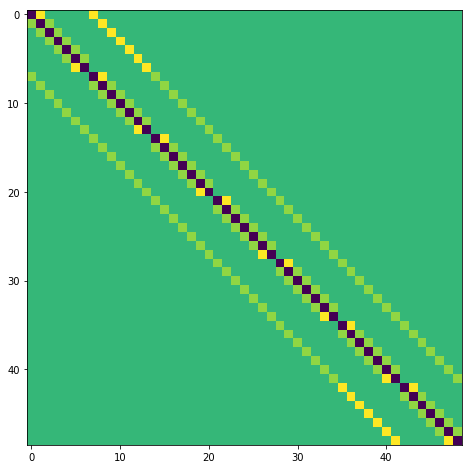

In [36]:
plt.imshow(fsf.D)
np.sum(fsf.D, axis=1)

In [37]:
parameters = [0.01, 1.6, 1/3, (0.2)/4, 1/(1/12), 0.1, 0.005, 0.075]

func = lambda t, y: fsf.model(t, y, parameters)

initial_state = fsf.default_ic()

solution_fine = integrate.solve_ivp(func, [0, 50], initial_state, max_step=1/12, dense_output=True)

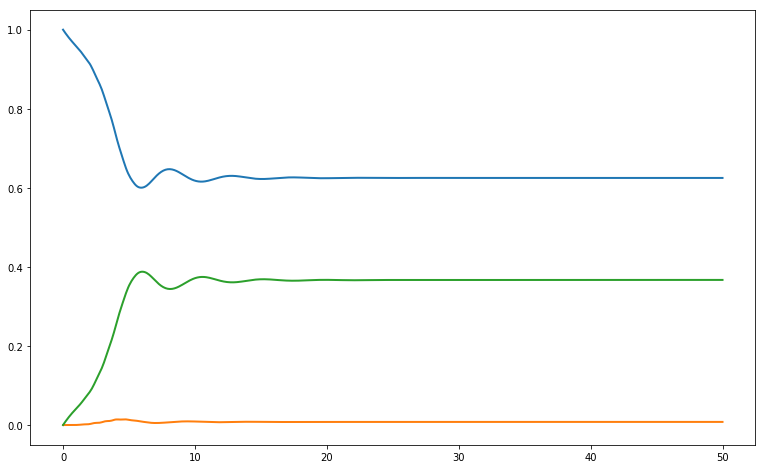

In [44]:
plt.figure()
plt.plot(solution_fine.t, aug(solution_fine.y, fsf.GRIDDING**2).T, linewidth=2);

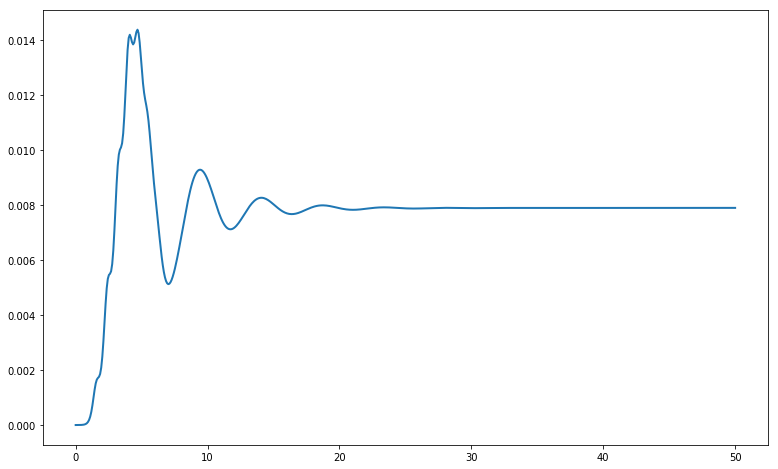

In [45]:
plt.figure()
plt.plot(solution_fine.t, aug(solution_fine.y, fsf.GRIDDING**2)[1,:].T, linewidth=2);

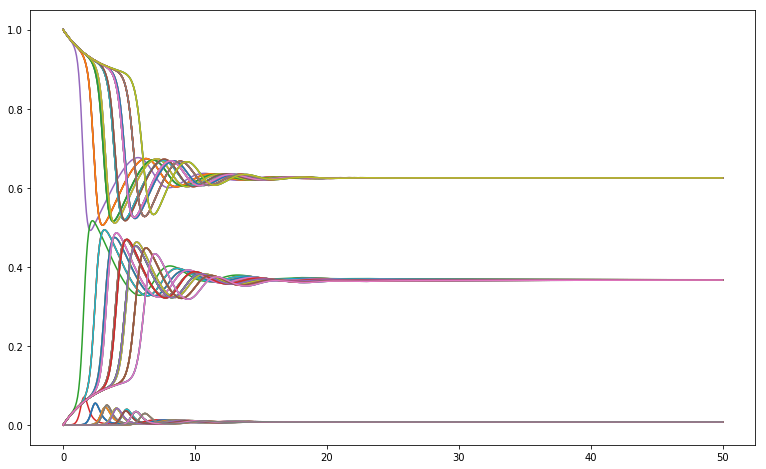

In [46]:
plt.figure()
plt.plot(solution_fine.t, solution_fine.y.T);